In [ ]:
!pip install audiomentations
! pip install librosa
!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.1/66.1 KB 1.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets
from torchvision import transforms
import os

from torch.utils.data.sampler import SubsetRandomSampler


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#output_size = (input_size - kernel_size + 2*padding) / stride + 1

In [ ]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
!cd drive/MyDrive/CS472/FinalTesting/DataSets && pwd

/content/drive/MyDrive/CS472/FinalTesting/DataSets


In [ ]:
path = '/content/drive/MyDrive/CS472/FinalTesting/DataSets'

!cd path && ls

os.chdir(path)
os.listdir()

/bin/bash: line 0: cd: path: No such file or directory


['IRMAS-TrainingData']

In [ ]:
# #this allowed me to download dataset directly to google drive

# !cd /content/drive/MyDrive/CS472/FinalTesting/DataSets && wget https://zenodo.org/record/1290750/files/IRMAS-TrainingData.zip?download=1
# !cd /content/drive/MyDrive/CS472/FinalTesting/DataSets && mv 'IRMAS-TrainingData.zip?download=1' IRMAS-TrainingData.zip && unzip IRMAS-TrainingData.zip && rm -r IRMAS-TrainingData.zip


In [ ]:
! pwd

/content/drive/MyDrive/CS472/FinalTesting/DataSets


In [ ]:
!ls

IRMAS-TrainingData


In [ ]:
class Cycler:
    def __init__(self):
      self.c = []
      self.i = 0


    def fromList(self, c_list):
        self.c = c_list
        self.i = 0

    def next(self):
      if len(self.c) <= self.i:
        return None
      else:
        item = self.c[self.i]
        self.i += 1
        return item

    def skip(self, num):
      self.i += num

    def reset(self):
      self.i = 0

    def __getitem__(self, idx):
      return self.c[idx]

    def __len__(self):
      return len(self.c)


    def toList(self):
        return self.c



In [ ]:
from re import I
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import librosa
import math
import random
import audiomentations as A
import wave
import torch.nn.functional as F

import librosa
import librosa.display
import matplotlib.pyplot as plt


from scipy.io import wavfile as wav




class IRMASDataset(Dataset):
    def __init__(self, root_dir, included_labels = [], segment_percent= .1, train_percentage= .8, noise_percentage= .1, use_random=True):
        self.root_dir = root_dir
        self.use_random = use_random #this won't work if its not random 155

        self.included_labels = included_labels

        # shift will acquire the number of splits for audio file
        self.shift = int(1/ segment_percent) # also num_features
        self.segment_percent = segment_percent
        self.num_features = 30

        # datastructures
        self.file_list = []
        self.instrument_dict = {}
        self.train_data_dict = {}
        self.val_data_dict = {}
        self.test_data_dict = {}
        self.val_seg_list = []
        self.test_seg_list = []
        self.train_seg_list = []

        self.first_file = None

        #Information for dataloader partitioning
        self.val_percentage = .2 * train_percentage #change this to increase validation percentage
        self.train_percentage = train_percentage - (self.val_percentage)# change this to change everything else
        self.test_percentage = 1 - train_percentage

        #Noise augmentation
        self.noise_aug = A.Compose([A.AddGaussianSNR(p=noise_percentage,
                                              min_snr_in_db=10,
                                              max_snr_in_db=20)])
        #initialization functions
        self.initialize_data_structs()
        self.separate_train_test()

        #data structures/values that need to be initialized after above functions
        self.val_cut_off = int(len(self.file_list) * self.train_percentage)
        self.train_cut_off = self.val_cut_off - int(self.val_cut_off * .2)

    def initialize_data_structs(self):
        instrument_dict = {}
        i = 0
        for root, dirs, files in os.walk(self.root_dir):
            for file in files:
                if file.endswith('.wav'):
                    file_name = os.path.join(root, file)
                    parent_dir = Path(file_name).parent.name
                    if parent_dir not in self.instrument_dict and parent_dir in self.included_labels:
                        self.instrument_dict[parent_dir] = i
                        i += 1
                        self.train_data_dict[parent_dir] = []
                        self.train_data_dict[parent_dir].append(file_name); self.file_list.append(file_name)
                    elif parent_dir in self.instrument_dict:
                        self.train_data_dict[parent_dir].append(file_name); self.file_list.append(file_name)
        if self.use_random:
          for instrument in self.train_data_dict:
            random.shuffle(self.train_data_dict[instrument])
          random.shuffle(self.file_list)

    def separate_train_test(self):
        for instrument in self.train_data_dict:
          train_cut_off = int(len(self.train_data_dict[instrument]) * self.train_percentage)
          val_cut_off = int(len(self.train_data_dict[instrument]) * self.val_percentage) + train_cut_off
          q1 = Cycler(); q1.fromList(self.train_data_dict[instrument][:train_cut_off])
          q2 = Cycler(); q2.fromList(self.train_data_dict[instrument][train_cut_off + 1:val_cut_off])
          q3 = Cycler(); q3.fromList(self.train_data_dict[instrument][val_cut_off +1:])
          self.train_data_dict[instrument] = q1
          self.val_data_dict[instrument] = q2
          self.test_data_dict[instrument] = q3

    def get_segment_list(self, target_dict):
        segment_list = []
        for instrument in target_dict:
            file_name = target_dict[instrument].next()
            if file_name == None:
                continue
            if self.first_file == None:
                self.first_file = file_name
            label = torch.tensor(self.instrument_dict[instrument])
            audio, sr = librosa.load(file_name, sr=None)
            #augmented = self.noise_aug(audio)
            #audio = augmented['audio']
            mfcc = librosa.feature.mfcc(audio, sr=sr, n_mfcc=self.num_features)
            mfcc = (mfcc - np.mean(mfcc)) / np.std(mfcc)
            frame_length = int(260 * self.segment_percent)  # number of frames per chunk
            num_frames = mfcc.shape[1]
            num_chunks = int(np.ceil(num_frames / frame_length))
            mfcc_frames = np.zeros((num_chunks, self.num_features, frame_length))
            for i in range(num_chunks):
                start = i * frame_length
                end = min(num_frames, start + frame_length)
                mfcc_frames[i, :, :end-start] = mfcc[:, start:end]
            mfcc_frames_tensor = torch.tensor(mfcc_frames, dtype=torch.float32)
            for frame in mfcc_frames_tensor:
                segment = frame.clone().detach().float().unsqueeze(0)
                segment_list.append( (segment, label) )

        random.shuffle(segment_list)
        if len(segment_list) == 0:
            self.reset_cycles(target_dict)
            return self.get_segment_list(target_dict)
        return segment_list

    def get_first_file(self):
      return self.first_file

    def reset_cycles(self, target_dict):
      for instrument in target_dict:
        target_dict[instrument].reset()


    def full_reset(self):
      self.train_seg_list.clear()
      self.val_seg_list.clear()
      self.test_seg_list.clear()
      self.reset_cycles(self.train_data_dict)
      self.reset_cycles(self.val_data_dict)
      self.reset_cycles(self.test_data_dict)


    def __getitem__(self, idx):
        idx = idx // self.shift
        if idx <= self.train_cut_off:
          if len(self.train_seg_list) == 0:
            self.train_seg_list = self.get_segment_list(self.train_data_dict)
          mfcc_tensor, label_tensor = self.train_seg_list.pop()
          return mfcc_tensor, label_tensor
        elif idx > self.train_cut_off and idx <= self.val_cut_off:
          if len(self.val_seg_list) == 0:
            self.val_seg_list = self.get_segment_list(self.val_data_dict)
          mfcc_tensor, label_tensor = self.val_seg_list.pop()
          return mfcc_tensor, label_tensor
        else:
          if len(self.test_seg_list) == 0:
            self.test_seg_list = self.get_segment_list(self.test_data_dict)
          mfcc_tensor, label_tensor = self.test_seg_list.pop()
          return mfcc_tensor, label_tensor


    def __len__(self):
      return len(self.file_list) * self.shift

    def increment_cycles(self, splits):
      for inst in self.train_data_dict:
        increment = len(self.train_data_dict[inst]) // splits
        self.train_data_dict[inst].skip(increment)
      for inst in self.val_data_dict:
        increment = len(self.val_data_dict[inst]) // splits
        self.val_data_dict[inst].skip(increment)
      for inst in self.test_data_dict:
        increment = len(self.test_data_dict[inst]) // splits
        self.test_data_dict[inst].skip(increment)

    def get_label(self, filename):
        return self.instrument_dict[Path(filename).parent.name]

    def get_number_of_labels(self):
      return len(self.instrument_dict)

labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org", "pia"]

IRMAS_ds = IRMASDataset("IRMAS-TrainingData", included_labels= labels)



In [ ]:
# # used to combine
def collate_fn(batch):
  inputs, targets = zip(*batch) #separtes data and target tensors into separate lists. Target tensors are the labels
  inputs_padded = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True) #padd the batches with zero if they are not filled
  targets_padded = torch.stack(targets) #padds the targets with 0's until it is filled
  return inputs_padded, targets_padded

In [ ]:
from torch.utils.data import DataLoader, SubsetRandomSampler

import copy

torch.manual_seed(42)


def split_samples(dataset, num_splits=10, batch_size = 256, num_workers= 2):
  num_files = len(dataset)
  dataset.full_reset()

  dataset_copies = []
  train_dsLoader_list = []
  val_dsLoader_list = []
  test_dsLoader_list = []
  train_percentage = dataset.train_percentage
  val_percentage = dataset.val_percentage
  test_percentage = dataset.test_percentage

  train_start = 0
  val_start = dataset.train_cut_off * dataset.shift
  test_start = dataset.val_cut_off * dataset.shift

  train_increment = int(train_percentage* num_files // num_splits)
  val_increment = int(val_percentage * num_files // num_splits)
  test_increment = int(test_percentage * num_files // num_splits)

  train_prev = train_start
  val_prev = val_start
  test_prev = test_start

  train_next = train_prev + train_increment
  val_next = val_prev + val_increment
  test_next = test_prev + test_increment
  print(f"split {num_files} inputs by {num_splits} splits: train size= {train_increment}, validation size= {val_increment}, test size= {test_increment}")
  skip_len = 0
  current_dataset = copy.deepcopy(dataset)
  for i in range(num_splits):
    train_dsLoader_list.append( DataLoader(current_dataset,
                                           num_workers=num_workers,
                                           batch_size= batch_size,
                                           sampler= SubsetRandomSampler(range(train_prev, train_next)),
                                           collate_fn= collate_fn
                                           ) )
    train_prev = train_next + 1
    train_next += train_increment
    val_dsLoader_list.append(DataLoader(current_dataset,
                                        num_workers=num_workers,
                                        batch_size= batch_size,
                                        sampler= SubsetRandomSampler(range(val_prev, val_next)),
                                        collate_fn= collate_fn
                                        ) )
    val_prev = val_next + 1
    val_next += val_increment
    test_dsLoader_list.append( DataLoader(current_dataset,
                                          num_workers=num_workers,
                                          batch_size= batch_size,
                                          sampler= SubsetRandomSampler(range(test_prev, test_next)),
                                          collate_fn= collate_fn
                                          ) )
    test_prev = test_next + 1
    test_next += test_increment
    dataset_copies.append(current_dataset)
    current_dataset = copy.deepcopy(current_dataset)
    current_dataset.increment_cycles(num_splits)

  return train_dsLoader_list, val_dsLoader_list, test_dsLoader_list, dataset_copies



In [ ]:
from typing_extensions import dataclass_transform
batch_size = 512
train_dsLoader_list, val_dsLoader_list, test_dsLoader_list, dataset_copies = split_samples(IRMAS_ds, num_splits = 1, batch_size= batch_size) #dataset, num_workers =2, num_splits, batch_size = 2


# data, label = next(iter(train_dsLoader_list[0]))
# data1, label1 = next(iter(train_dsLoader_list[5]))
# print(data[0][0][30])
# print(data1[0][0][30])




split 67050 inputs by 1 splits: train size= 42912, validation size= 10728, test size= 13409


Test to show the data sets are not equal, each time it a dataloader
is called it copies the current dataset state it is assigned to by
making copies it refers to the state of the copy.

Copy of output:

tensor([0.1227, 0.0205, 0.0053, 0.1575, 0.1030, 0.0833, 0.1713, 0.1905, 0.1395, 0.1874, 0.1687, 0.0704, 0.0523])

tensor([-0.4809, -0.5016, -0.5025, -0.4433, -0.3915, -0.3718, -0.2472, -0.2602, -0.2802, -0.2363, -0.1246, -0.1997, -0.1865])

In [ ]:
sample_idx = 0 # index of the sample to retrieve
print(f"Number of instruments: {len(IRMAS_ds.instrument_dict)}\n")
#print(IRMAS_ds.data_dict.keys())
print(f"Shape of output: {IRMAS_ds[0][0].shape} \n")  #torch.Size([1, 50, 13])
print(f"Number of wave files: {len(IRMAS_ds) // 40}\n")

#if you set segment_percentage to .1 the resulting shape will be 26 by 26.


train_keys = "Train keys: "
for key in IRMAS_ds.train_data_dict:
  train_keys += (f" {key}:{len(IRMAS_ds.train_data_dict[key])}")
print(train_keys)

val_keys = "\nVal keys: "
for key in IRMAS_ds.train_data_dict:
  val_keys += (f" {key}:{len(IRMAS_ds.val_data_dict[key])}")
print(val_keys)

test_keys = "\nTest keys: "
for key in IRMAS_ds.test_data_dict:
  test_keys += f" {key}:{len(IRMAS_ds.test_data_dict[key])} "
print(test_keys)




Number of instruments: 4

Shape of output: torch.Size([1, 30, 26]) 

Number of wave files: 640

Train keys:  sax:400 tru:369 vio:371 voi:497

Val keys:  sax:99 tru:91 vio:91 voi:123

Test keys:  sax:125  tru:115  vio:116  voi:156 


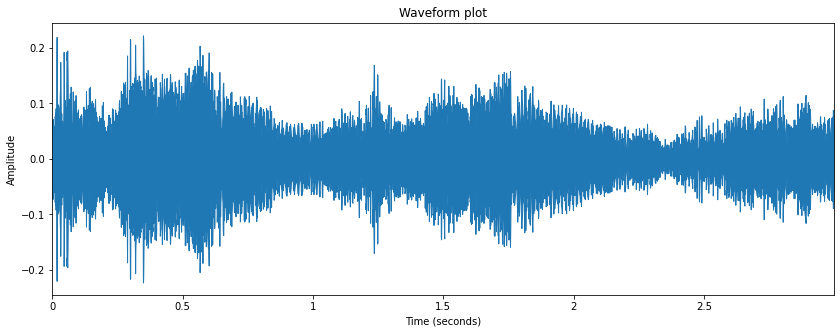

     View of Working SpectroGram
tensor(2)
torch.Size([1, 30, 26])


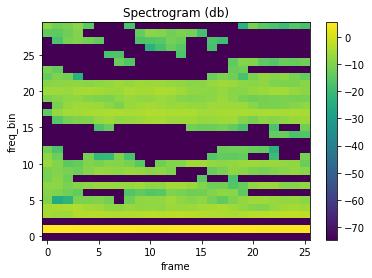


   View of full spectroGram


/usr/local/lib/python3.9/dist-packages/torchaudio/functional/functional.py:571: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (256) may be set too high. Or, the value for `n_freqs` (1025) may be set too low.
  warnings.warn(


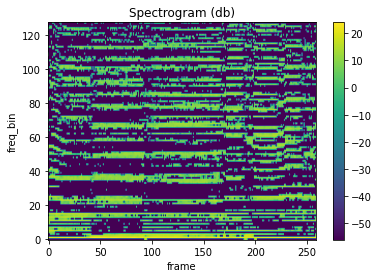

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random

import torchaudio
import torchaudio.transforms as T


# load audio file
audio, sr = librosa.load(IRMAS_ds.file_list[random.randint(0, len(IRMAS_ds.file_list) - 1)])

# plot waveform
plt.figure(figsize=(14, 5))
librosa.display.waveplot(audio, sr=sr)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title('Waveform plot')
plt.show()


def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)


def get_wf_sr(file_name):
    effects = [["remix", "1"]]
    return torchaudio.sox_effects.apply_effects_file(file_name, effects=effects)


def convert_waveform_to_mfcc(waveform, sr):
    n_fft = 2048
    win_length = None
    hop_length = 512
    n_mels = 256
    n_mfcc = 128
    mfcc_transform = T.MFCC(
        sample_rate=sr,
        n_mfcc=n_mfcc,
        melkwargs={
          'n_fft': n_fft,
          'n_mels': n_mels,
          'hop_length': hop_length,
          'mel_scale': 'htk',
        }
    )
    return mfcc_transform(waveform)

IRMAS_ds.full_reset()

print("     View of Working SpectroGram")
item = IRMAS_ds[0]
print(item[1])
print(item[0].shape)
plot_spectrogram(item[0][0])

file_name = IRMAS_ds.get_first_file()


print("\n   View of full spectroGram")
wf, sr = get_wf_sr(file_name)
mfcc = convert_waveform_to_mfcc(wf, sr)
plot_spectrogram(mfcc[0])


# for instrument in IRMAS_ds.train_data_dict:
#   # sample = cycle.next()
#   print(instrument)
#   file_name = IRMAS_ds.train_data_dict[instrument].next()
#   wf, sr = get_wf_sr(file_name)
#   mfcc = convert_waveform_to_mfcc(wf, sr)
#   plot_spectrogram(mfcc[0])



In [ ]:
# #verify there is data in the the test and train loaders, commented out as it takes a long time to run

# data, label = next(iter(train_dsLoader_list[0]))
# print(f"train targets: {label}, {data.shape}, {len(data)}")

# data, label = next(iter(val_dsLoader_list[0]))
# print(f"val targets: {label}, {data.shape}, {len(data)}")

# data, label = next(iter(test_dsLoader_list[0]))
# print(f"test targets: {label}, {data.shape}, {len(data)}")



output_length = (input_length + 2 * padding - dilation * (kernel_size -1) - 1) / stride + 1

output_shape = (batch_size, out_channels, output_length)


In [ ]:
class LinearNet(nn.Module):
    def __init__(self,
                 ninputs= 780,   # number of inputs (30x30)
                 nhidden=100,   # number of nodes in hidden layer
                 nout=11,       # output
                 nLayers = 2,
                 channels = 1,
                 dropout_prob=0.5
                ):
        super().__init__()
        layers = [nn.Linear(ninputs, nhidden), nn.ReLU()]

        for i in range(nLayers):
          layers += [nn.Linear(nhidden, nhidden), nn.ReLU()]

        layers += [nn.Linear(nhidden, nout, bias=False)]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        b, c, h, w = x.shape
        x = x.view(b, -1) # Flatten image
        x = self.net(x)
        x = F.softmax(x, dim=1)
        return x


In [ ]:
class CNN(nn.Module):
    def __init__(self, num_classes, dropout_prob=0.5):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64*7*6, 128)  # update the number of units to 64*7*6
        self.fc2 = nn.Linear(128, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 64*7*6)  # update the shape of the tensor
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [ ]:
class ResBlock(nn.Module):
    def __init__(self, inChannels, outChannels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(inChannels,
                               outChannels,
                               kernel_size=3,
                               stride=stride,
                               padding=1,
                               bias=False)
        self.bn = nn.BatchNorm2d(outChannels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(outChannels, outChannels, kernel_size=3, stride=1,
                               padding=1, bias=False)
        self.downsample = downsample


    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=11, dropout_prob=0.5):
        super(ResNet, self).__init__()
        self.inChannels = 64
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.fc = nn.Linear(512, num_classes)

    def _make_layer(self, block, outChannels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inChannels != outChannels:
            downsample = nn.Sequential(
                nn.Conv2d(self.inChannels, outChannels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(outChannels),
            )

        layers = []
        layers.append(block(self.inChannels, outChannels, stride, downsample))
        self.inChannels = outChannels
        for i in range(1, blocks):
            layers.append(block(self.inChannels, outChannels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)

        return x


In [ ]:
import time
import matplotlib.pyplot as plt
from tqdm import tqdm # This is optional but useful
import gc

CUDA_LAUNCH_BLOCKING=1

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'



class Trainer():
    def __init__(self, model, dataset, num_splits= 20, num_epochs= 10):
        #hyper Parameters
        self.num_epochs = num_epochs
        self.lr = .001
        self.batch_size = 512
        self.num_splits = num_splits
        self.train_list, self.val_list, self.test_list, self.dataset_copies = split_samples(IRMAS_ds,
                                                                                            num_splits = self.num_splits,
                                                                                            batch_size= self.batch_size)

        self.dataset = dataset
        self.total_loss = []
        self.total_val_loss = []

        self.num_labels = dataset.get_number_of_labels()
        self.num_channels = 0
        self.num_frames = 0
        self.num_features =  0
        self.get_data_info()
        self.model = model
        #self.model = model(ResBlock, [3,4,6,3], num_classes= num_labels).to(device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = torch.optim.SGD(self.model.parameters(), lr=self.lr, weight_decay= .001, momentum= .09)
        #weight decay is done to prevent overfitting, it does this by adding a penalty to the loss function to make it have smaller values
        #momentum helps smooth out the update process and make learning happen quicker

    def get_data_info(self):
        extract_mfcc_tensor, label = self.dataset[0]
        self.num_channels, self.num_frames, self.num_features = extract_mfcc_tensor.shape

    def train_over_partition(self, partition_num):
        if partition_num > self.num_splits or partition_num < 0:
            print(f"num_partition must be >=0 and  < {self.num_splits}")
        train_loader = self.train_list[partition_num]
        valid_loader = self.val_list[partition_num]
        test_loader = self.test_list[partition_num]

        self.model.train()
        loss_history = []
        val_loss_history = []
        loss = torch.Tensor([0])

        start_time = time.time() # Start time

        for epoch in tqdm(range(self.num_epochs), desc=f"Epoch", unit="epoch", disable=False):
            prev_val_loader = None
            for (images, labels) in tqdm(train_loader, desc="iteration", unit="%", disable=True):
                self.optimizer.zero_grad(set_to_none=True)
                images = images.to(device)
                labels = labels.to(device)
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()
                loss_history.append(loss.item())
                del images, labels, outputs
                torch.cuda.empty_cache()
                gc.collect()
            if prev_val_loader != None:
                for (images, labels) in tqdm(prev_val_loader, desc="iteration", unit="%", disable=True):
                    self.optimizer.zero_grad(set_to_none=True)
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    loss = self.criterion(outputs, labels)
                    loss.backward()
                    self.optimizer.step()
                    loss_history.append(loss.item())
                    del images, labels, outputs
                    torch.cuda.empty_cache()
                    gc.collect()
            # Validation loop
            self.model.eval()
            with torch.no_grad():
                for (images, labels) in valid_loader:
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = self.model(images)
                    val_loss = self.criterion(outputs, labels)
                    val_loss_history.append(val_loss.item())
                    del images, labels, outputs
                    torch.cuda.empty_cache()
                    gc.collect()
            self.model.train()
            # Print epoch and losses
            avg_train_loss = sum(loss_history) / len(loss_history)
            avg_val_loss = sum(val_loss_history) / len(val_loss_history)
            print(f"Epoch {epoch}: train_loss: {avg_train_loss:.5f}, val_loss: {avg_val_loss:.5f}")
        prev_val_loader = valid_loader
        end_time = time.time() # End time
        print(f"Total training time: {(end_time - start_time) / 60:.2f} minutes")

        self.total_loss.extend(loss_history)
        self.total_val_loss.extend(val_loss_history)
        plt.plot(self.total_loss, label='Training set')
        plt.plot(self.total_val_loss, label='Validation set')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

        correct = 0
        total = 0
        with torch.no_grad():
          for data in self.test_list[partition_num]:
              inputs, labels = data
              inputs = inputs.to(device)
              labels = labels.to(device)
              outputs = self.model(inputs)
              _, predicted = torch.max(outputs.data, 1)
              total += labels.size(0)
              correct += (predicted == labels).sum().item()
        print(f"Accuracy of the network on the test set: {round((100 * correct / total), 2)}%\n")

    def only_test(self):
        correct = 0
        total = 0
        with torch.no_grad():
          for test_partition in self.test_list:
            for data in test_partition:
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print(f"Accuracy of the network on the test set: {round((100 * correct / total), 2)}%\n")


    def train_over_range(self, start, end):
        for i in range(start, end + 1):
          print(f"\npartition: {i}/{end}\n")
          self.train_over_partition(i)





In [ ]:
# model = LinearNet().to(device)
# trainer = Trainer(model, IRMAS_ds, num_splits= 5, epochs= 2)
# trainer.train_over_range(0, 4)


In [ ]:
# model = CNN(11).to(device)
# trainer = Trainer(model, IRMAS_ds, num_splits= 5, num_epochs= 10)
# trainer.train_over_range(0, 4) #error here, original had set to 5, but that would be 6 partitions

split 12030 inputs by 10 splits: train size= 769, validation size= 192, test size= 240


Epoch:  10%|█         | 1/10 [00:08<01:14,  8.29s/epoch]

Epoch 0: train_loss: 3.93713, val_loss: 2.45236


Epoch:  20%|██        | 2/10 [00:11<00:43,  5.49s/epoch]

Epoch 1: train_loss: 3.46799, val_loss: 2.44089


Epoch:  30%|███       | 3/10 [00:15<00:31,  4.50s/epoch]

Epoch 2: train_loss: 3.08301, val_loss: 2.40730


Epoch:  40%|████      | 4/10 [00:18<00:24,  4.15s/epoch]

Epoch 3: train_loss: 2.73746, val_loss: 2.35892


Epoch:  50%|█████     | 5/10 [00:22<00:19,  3.90s/epoch]

Epoch 4: train_loss: 2.43396, val_loss: 2.30376


Epoch:  60%|██████    | 6/10 [00:25<00:15,  3.86s/epoch]

Epoch 5: train_loss: 2.16968, val_loss: 2.24804


Epoch:  70%|███████   | 7/10 [00:29<00:11,  3.79s/epoch]

Epoch 6: train_loss: 1.95011, val_loss: 2.19473


Epoch:  80%|████████  | 8/10 [00:33<00:07,  3.68s/epoch]

Epoch 7: train_loss: 1.76693, val_loss: 2.14526


Epoch:  90%|█████████ | 9/10 [00:36<00:03,  3.60s/epoch]

Epoch 8: train_loss: 1.60941, val_loss: 2.09757


Epoch: 100%|██████████| 10/10 [00:40<00:00,  4.08s/epoch]

Epoch 9: train_loss: 1.47575, val_loss: 2.05368
Total training time: 0.68 minutes


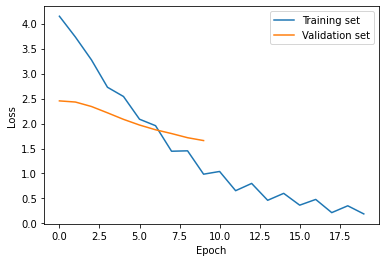

Accuracy of the network on the test set: 60.83%

split 13580 inputs by 10 splits: train size= 869, validation size= 217, test size= 271


Epoch:  10%|█         | 1/10 [00:30<04:32, 30.22s/epoch]

Epoch 0: train_loss: 1.18204, val_loss: 1.60714


Epoch:  20%|██        | 2/10 [00:33<01:57, 14.63s/epoch]

Epoch 1: train_loss: 0.87727, val_loss: 1.56985


Epoch:  30%|███       | 3/10 [00:38<01:10, 10.03s/epoch]

Epoch 2: train_loss: 0.70375, val_loss: 1.54313


Epoch:  40%|████      | 4/10 [00:42<00:45,  7.54s/epoch]

Epoch 3: train_loss: 0.59370, val_loss: 1.52614


Epoch:  50%|█████     | 5/10 [00:45<00:30,  6.15s/epoch]

Epoch 4: train_loss: 0.51701, val_loss: 1.50927


Epoch:  60%|██████    | 6/10 [00:50<00:22,  5.62s/epoch]

Epoch 5: train_loss: 0.45331, val_loss: 1.49089


Epoch:  70%|███████   | 7/10 [00:54<00:14,  4.95s/epoch]

Epoch 6: train_loss: 0.40300, val_loss: 1.47403


Epoch:  80%|████████  | 8/10 [00:57<00:09,  4.55s/epoch]

Epoch 7: train_loss: 0.36371, val_loss: 1.45848


Epoch:  90%|█████████ | 9/10 [01:02<00:04,  4.49s/epoch]

Epoch 8: train_loss: 0.33099, val_loss: 1.44403


Epoch: 100%|██████████| 10/10 [01:05<00:00,  6.58s/epoch]

Epoch 9: train_loss: 0.30415, val_loss: 1.43123
Total training time: 1.10 minutes


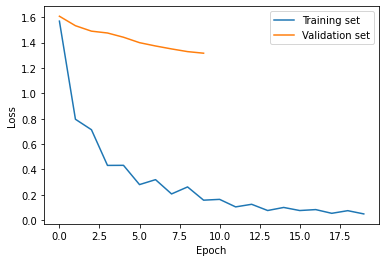

Accuracy of the network on the test set: 74.91%

split 8930 inputs by 10 splits: train size= 571, validation size= 142, test size= 178


Epoch:  10%|█         | 1/10 [00:22<03:20, 22.29s/epoch]

Epoch 0: train_loss: 1.71470, val_loss: 1.75818


Epoch:  20%|██        | 2/10 [00:25<01:29, 11.23s/epoch]

Epoch 1: train_loss: 1.29509, val_loss: 1.54932


Epoch:  30%|███       | 3/10 [00:28<00:51,  7.37s/epoch]

Epoch 2: train_loss: 1.07561, val_loss: 1.43062


Epoch:  40%|████      | 4/10 [00:31<00:33,  5.53s/epoch]

Epoch 3: train_loss: 0.89871, val_loss: 1.37308


Epoch:  50%|█████     | 5/10 [00:33<00:22,  4.51s/epoch]

Epoch 4: train_loss: 0.77370, val_loss: 1.33315


Epoch:  60%|██████    | 6/10 [00:37<00:16,  4.05s/epoch]

Epoch 5: train_loss: 0.67494, val_loss: 1.30576


Epoch:  70%|███████   | 7/10 [00:40<00:11,  3.69s/epoch]

Epoch 6: train_loss: 0.59810, val_loss: 1.28552


Epoch:  80%|████████  | 8/10 [00:42<00:06,  3.37s/epoch]

Epoch 7: train_loss: 0.53711, val_loss: 1.27063


Epoch:  90%|█████████ | 9/10 [00:45<00:03,  3.17s/epoch]

Epoch 8: train_loss: 0.48745, val_loss: 1.25902


Epoch: 100%|██████████| 10/10 [00:48<00:00,  4.84s/epoch]

Epoch 9: train_loss: 0.44576, val_loss: 1.24799
Total training time: 0.81 minutes


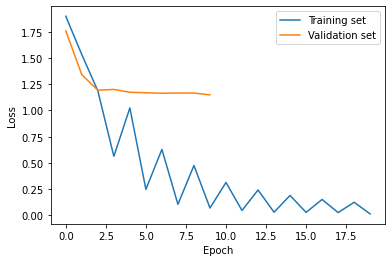

Accuracy of the network on the test set: 74.72%

split 10880 inputs by 10 splits: train size= 696, validation size= 174, test size= 217


Epoch:  10%|█         | 1/10 [00:29<04:23, 29.31s/epoch]

Epoch 0: train_loss: 1.58068, val_loss: 1.04712


Epoch:  20%|██        | 2/10 [00:32<01:53, 14.13s/epoch]

Epoch 1: train_loss: 0.98931, val_loss: 1.03084


Epoch:  30%|███       | 3/10 [00:36<01:04,  9.21s/epoch]

Epoch 2: train_loss: 0.73727, val_loss: 1.04196


Epoch:  40%|████      | 4/10 [00:39<00:40,  6.76s/epoch]

Epoch 3: train_loss: 0.58875, val_loss: 1.05541


Epoch:  50%|█████     | 5/10 [00:42<00:27,  5.53s/epoch]

Epoch 4: train_loss: 0.49037, val_loss: 1.07251


Epoch:  60%|██████    | 6/10 [00:46<00:19,  4.89s/epoch]

Epoch 5: train_loss: 0.42013, val_loss: 1.08999


Epoch:  70%|███████   | 7/10 [00:49<00:13,  4.49s/epoch]

Epoch 6: train_loss: 0.36802, val_loss: 1.10444


Epoch:  80%|████████  | 8/10 [00:53<00:08,  4.12s/epoch]

Epoch 7: train_loss: 0.32845, val_loss: 1.12110


Epoch:  90%|█████████ | 9/10 [00:56<00:03,  3.84s/epoch]

Epoch 8: train_loss: 0.29714, val_loss: 1.13492


Epoch: 100%|██████████| 10/10 [01:00<00:00,  6.03s/epoch]

Epoch 9: train_loss: 0.27103, val_loss: 1.14809
Total training time: 1.01 minutes


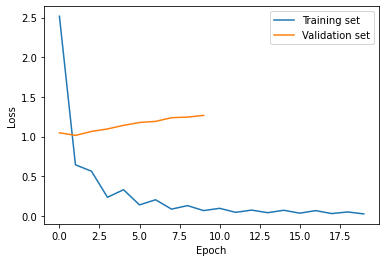

Accuracy of the network on the test set: 80.18%

split 14420 inputs by 10 splits: train size= 922, validation size= 230, test size= 288


Epoch:  10%|█         | 1/10 [00:32<04:55, 32.85s/epoch]

Epoch 0: train_loss: 1.27958, val_loss: 1.22055


Epoch:  20%|██        | 2/10 [00:36<02:07, 15.91s/epoch]

Epoch 1: train_loss: 0.81551, val_loss: 1.16891


Epoch:  30%|███       | 3/10 [00:41<01:13, 10.52s/epoch]

Epoch 2: train_loss: 0.60453, val_loss: 1.14398


Epoch:  40%|████      | 4/10 [00:44<00:47,  7.88s/epoch]

Epoch 3: train_loss: 0.48234, val_loss: 1.13062


Epoch:  50%|█████     | 5/10 [00:48<00:32,  6.44s/epoch]

Epoch 4: train_loss: 0.40359, val_loss: 1.11523


Epoch:  60%|██████    | 6/10 [00:52<00:22,  5.60s/epoch]

Epoch 5: train_loss: 0.34833, val_loss: 1.10446


Epoch:  70%|███████   | 7/10 [00:57<00:15,  5.20s/epoch]

Epoch 6: train_loss: 0.30682, val_loss: 1.09713


Epoch:  80%|████████  | 8/10 [01:00<00:09,  4.77s/epoch]

Epoch 7: train_loss: 0.27410, val_loss: 1.09004


Epoch:  90%|█████████ | 9/10 [01:04<00:04,  4.54s/epoch]

Epoch 8: train_loss: 0.24811, val_loss: 1.08642


Epoch: 100%|██████████| 10/10 [01:09<00:00,  6.99s/epoch]

Epoch 9: train_loss: 0.22742, val_loss: 1.08296
Total training time: 1.17 minutes


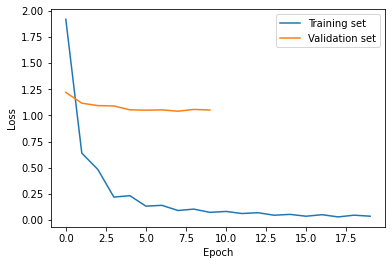

Accuracy of the network on the test set: 66.32%



In [ ]:
model = ResNet(ResBlock, [3, 4, 6, 3]).to(device)
labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org", "pia"]

train_labels = []
for label in labels:
    train_labels.append(label)
    if len(train_labels) == 2:
        IRMAS_ds = IRMASDataset("IRMAS-TrainingData", included_labels= train_labels)
        temp_trainer = Trainer(model, IRMAS_ds, num_splits= 10, num_epochs= 10)
        temp_trainer.train_over_partition(0)
        train_labels.clear()


In [ ]:
labels = ["sax", "tru", "vio", "voi", "cel", "cla", "flu", "gac", "gel", "org"] # no piano
IRMAS_ds = IRMASDataset("IRMAS-TrainingData", included_labels= labels)
trainer = Trainer(model, IRMAS_ds, num_splits= 10, num_epochs= 10)
trainer.only_test()

split 59840 inputs by 10 splits: train size= 3829, validation size= 957, test size= 1196
Accuracy of the network on the test set: 8.69%

